In [1]:
import pickle
import pandas as pd
import numpy as np
import re
#import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
svd_df_daily = pd.read_csv('svd_df_daily.csv')

In [3]:
svd_df_daily.index = pd.to_datetime(svd_df_daily.date)
svd_df_daily = svd_df_daily.drop('date',axis=1)

In [4]:
svd_df_daily = svd_df_daily[['0','1']]
svd_df_daily.columns = ['svd_1','svd_2']
svd_df_daily.head()

,svd_1,svd_2
date,,
2009-05-04,1.917882,-0.737776
2009-05-05,1.734408,-0.729916
2009-05-08,0.656465,0.025012
2009-05-12,0.764610,-0.615122
2009-05-13,0.552576,-0.718454


In [5]:
futures_close = pd.read_csv('futures_close.csv')

In [6]:
futures_close.index = pd.to_datetime(futures_close.date)
futures_close = futures_close.drop(['date'],axis=1)
futures_close.head()

,ES,NQ,CD,EC,JY,MP,TY,US,C,S,W,CL,GC
date,,,,,,,,,,,,,
2014-01-02,1756.00,3701.00,0.94065,1.4714,10352.5,62420.0,113.98436,119.21875,640.00,1233.50,963.00,116.42,1330.6
2014-01-03,1755.00,3673.25,0.94465,1.4660,10355.5,62870.0,113.93749,119.12500,642.75,1234.50,970.50,114.94,1344.0
2014-01-06,1750.25,3659.50,0.94135,1.4697,10391.5,62870.0,114.23436,119.62500,646.75,1237.75,970.50,114.41,1343.4
2014-01-07,1760.25,3690.50,0.93175,1.4679,10370.5,63245.0,114.45311,119.90625,644.75,1235.00,967.00,114.65,1335.0
2014-01-08,1762.00,3706.50,0.92825,1.4644,10341.5,62720.0,113.87499,119.37500,636.25,1226.75,953.75,113.34,1330.9


In [7]:
pickle_in = open('vol.pkl',"rb")
vol_pd = pickle.load(pickle_in)
pickle_in.close()
#vol_pd.columns

In [8]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']

In [9]:
vol_dict = {inst:[key for key in vol_pd.columns if re.match(r"{}+".format(inst),key) ] for inst in instrument_list}
vol_dict['ES']

['ES_1M_atm_vol',
 'ES_1M_RR25',
 'ES_1M_RR10',
 'ES_1M_Fly25',
 'ES_1M_Fly10',
 'ES_2M_atm_vol',
 'ES_2M_RR25',
 'ES_2M_RR10',
 'ES_2M_Fly25',
 'ES_2M_Fly10',
 'ES_2M_1M_atm_vol']

In [10]:
vol_pd[vol_dict['ES']].head()

,ES_1M_atm_vol,ES_1M_RR25,ES_1M_RR10,ES_1M_Fly25,ES_1M_Fly10,ES_2M_atm_vol,ES_2M_RR25,ES_2M_RR10,ES_2M_Fly25,ES_2M_Fly10,ES_2M_1M_atm_vol
Date,,,,,,,,,,,
2016-11-14,0.119889,-0.037174,-0.073479,0.003789,0.015547,0.125210,-0.046645,-0.088709,0.004540,0.017257,0.005205
2016-11-15,0.097407,-0.019810,-0.038827,0.004464,0.018210,0.116007,-0.037339,-0.070383,0.004491,0.016703,0.018506
2016-11-16,0.086325,-0.015557,-0.032338,0.003478,0.014565,0.118026,-0.039720,-0.075981,0.004275,0.016356,0.031726
2016-11-17,0.078008,-0.013282,-0.026062,0.003378,0.013855,0.114574,-0.037722,-0.072023,0.003713,0.014712,0.036573
2016-11-18,0.062015,-0.009879,-0.019785,0.002611,0.011093,0.110443,-0.037831,-0.073675,0.002989,0.013092,0.048422


In [11]:
futures_close.head()

,ES,NQ,CD,EC,JY,MP,TY,US,C,S,W,CL,GC
date,,,,,,,,,,,,,
2014-01-02,1756.00,3701.00,0.94065,1.4714,10352.5,62420.0,113.98436,119.21875,640.00,1233.50,963.00,116.42,1330.6
2014-01-03,1755.00,3673.25,0.94465,1.4660,10355.5,62870.0,113.93749,119.12500,642.75,1234.50,970.50,114.94,1344.0
2014-01-06,1750.25,3659.50,0.94135,1.4697,10391.5,62870.0,114.23436,119.62500,646.75,1237.75,970.50,114.41,1343.4
2014-01-07,1760.25,3690.50,0.93175,1.4679,10370.5,63245.0,114.45311,119.90625,644.75,1235.00,967.00,114.65,1335.0
2014-01-08,1762.00,3706.50,0.92825,1.4644,10341.5,62720.0,113.87499,119.37500,636.25,1226.75,953.75,113.34,1330.9


In [12]:
#futures_returns = ( futures_close.shift(-2) - futures_close.shift(-1) ) / futures_close.shift(-1)
#y_rets = futures_returns.ES[futures_returns.index >= vol_pd.index[0]]
#y = 1 * ((futures_returns.ES[futures_returns.index >= vol_pd.index[0]] ) >=0)

In [13]:
futures_returns = ( futures_close.shift(-2) - futures_close.shift(-1) ) / futures_close.shift(-1)
y_rets_dict = {inst:futures_returns[inst][futures_returns.index >= vol_pd.index[0]] for inst in instrument_list}
y_dict = {inst: 1 * ((y_rets_dict[inst] -np.mean(y_rets_dict[inst])/2) >=0) for inst in instrument_list}

In [14]:
futures_returns.head()

,ES,NQ,CD,EC,JY,MP,TY,US,C,S,W,CL,GC
date,,,,,,,,,,,,,
2014-01-02,-0.002707,-0.003743,-0.003493,0.002524,0.003476,0.000000,0.002606,0.004197,0.006223,0.002633,0.000000,-0.004611,-0.000446
2014-01-03,0.005713,0.008471,-0.010198,-0.001225,-0.002021,0.005965,0.001915,0.002351,-0.003092,-0.002222,-0.003606,0.002098,-0.006253
2014-01-06,0.000994,0.004335,-0.003756,-0.002384,-0.002796,-0.008301,-0.005051,-0.004431,-0.013183,-0.006680,-0.013702,-0.011426,-0.003071
2014-01-07,0.000284,-0.004587,-0.005386,0.000546,0.000483,0.001196,0.001921,0.004712,-0.007859,0.003668,-0.005242,-0.005647,0.002930
2014-01-08,0.002695,0.003727,-0.002383,0.004778,0.006379,0.013536,0.008491,0.011464,0.032475,0.004061,-0.015283,0.009406,0.013111


In [15]:
futures_returns_60 = ( futures_close - futures_close.shift(60) ) / futures_close
futures_returns_60 = futures_returns_60.dropna()
futures_returns_60 = futures_returns_60[futures_returns_60.index >= vol_pd.index[0]]
futures_returns_60.columns = [col + '_60D' for col in futures_returns_60]
futures_returns_60.head()

,ES_60D,NQ_60D,CD_60D,EC_60D,JY_60D,MP_60D,TY_60D,US_60D,C_60D,S_60D,W_60D,CL_60D,GC_60D
date,,,,,,,,,,,,,
2016-11-14,-0.006767,-0.022287,-0.053804,-0.054960,-0.081135,-0.157175,-0.034673,-0.106425,-0.017609,-0.015978,-0.086814,-0.144283,-0.095242
2016-11-15,0.001933,-0.008576,-0.039369,-0.055864,-0.088359,-0.122509,-0.039253,-0.116360,-0.006349,-0.021204,-0.066504,-0.055193,-0.090763
2016-11-16,-0.002737,-0.006148,-0.040678,-0.057463,-0.087314,-0.112152,-0.038360,-0.110966,-0.001597,-0.022118,-0.060841,-0.075010,-0.093325
2016-11-17,0.007148,0.008965,-0.043173,-0.058785,-0.091834,-0.116890,-0.041625,-0.119403,0.006878,-0.011657,-0.049393,-0.051057,-0.086609
2016-11-18,0.006250,0.005818,-0.044325,-0.062671,-0.097524,-0.139628,-0.044703,-0.120591,0.022584,0.015635,-0.036903,-0.054236,-0.089553


In [16]:
vol_svd = vol_pd.join(svd_df_daily)
print(vol_svd.shape)
print(vol_pd.shape)

(753, 145)
(753, 143)


In [17]:
X_dict = {}
for inst in instrument_list:
    #X_dict[inst] = pd.concat([futures_returns_60[inst+'_60D'],vol_svd[['svd_1','svd_2']+vol_dict[inst]]],axis=1)
    X_dict[inst] = futures_returns_60[[inst+'_60D']].join(vol_svd[['svd_1','svd_2']+vol_dict[inst]])
    not_na_index =  (~y_dict[inst].isna()) 
    X_dict[inst] = X_dict[inst][not_na_index].fillna(X_dict[inst].mean())
    y_dict[inst] = y_dict[inst][not_na_index].fillna(X_dict[inst].mean())

In [18]:
X_dict['NQ']

,NQ_60D,svd_1,svd_2,NQ_1M_atm_vol,NQ_1M_RR25,NQ_1M_RR10,NQ_1M_Fly25,NQ_1M_Fly10,NQ_2M_atm_vol,NQ_2M_RR25,NQ_2M_RR10,NQ_2M_Fly25,NQ_2M_Fly10,NQ_2M_1M_atm_vol
date,,,,,,,,,,,,,,
2016-11-14,-0.022287,2.187404,-0.212503,0.158029,-0.046915,-0.092793,0.002713,0.013989,0.171299,-0.057862,-0.111408,0.003645,0.016765,0.013236
2016-11-15,-0.008576,2.164690,0.031882,0.132717,-0.032431,-0.064730,0.001872,0.009775,0.157155,-0.049535,-0.095997,0.002913,0.013924,0.024351
2016-11-16,-0.006148,1.496716,-0.346359,0.123424,-0.028098,-0.056410,0.001998,0.009874,0.153492,-0.048865,-0.093373,0.003782,0.015410,0.030005
2016-11-17,0.008965,0.901418,-0.964986,0.110205,-0.022478,-0.040027,0.001185,0.005983,0.143725,-0.044735,-0.084884,0.002986,0.013063,0.033514
2016-11-18,0.005818,2.331478,-0.444515,0.096395,-0.018662,-0.038627,0.001310,0.007318,0.141714,-0.043529,-0.084273,0.002073,0.011362,0.045396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-04,0.064662,2.187404,-0.212503,0.137706,-0.041597,-0.084117,0.003968,0.016507,0.143936,-0.044730,-0.089037,0.004455,0.018263,0.006214
2019-11-05,0.075480,2.187404,-0.212503,0.143018,-0.042914,-0.088045,0.004371,0.017983,0.148860,-0.045378,-0.091954,0.004682,0.019393,0.005724
2019-11-06,0.053002,2.187404,-0.212503,0.135142,-0.039549,-0.080711,0.004142,0.016865,0.142216,-0.042741,-0.086096,0.004694,0.018993,0.007073


In [19]:
#not_na_index =  ~y.isna()
#X = X[not_na_index]
#y = y[not_na_index]

In [20]:
y_dict['ES'].head()

date
2016-11-14    0
2016-11-15    1
2016-11-16    0
2016-11-17    1
2016-11-18    1
Name: ES, dtype: int32

In [21]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'MP', 'C', 'S', 'W', 'CL', 'GC']

In [22]:
strat_rets = pd.DataFrame()
strat_rets_cum = pd.DataFrame()
strat_port = pd.DataFrame()
strat_feat_imp = {}
for inst in instrument_list:
    X_train, X_test, y_train, y_test = train_test_split(X_dict[inst], y_dict[inst], test_size=0.50, shuffle=False )
    X_train, X_embargo, y_train, y_embargo = train_test_split(X_train, y_train, test_size=0.01, shuffle=False)
    #print(X_train)
    ddd = X_test.shape[0]
    random_forest = RandomForestClassifier(n_estimators=5000, max_features = 10, max_depth=15)
    random_forest.fit(X_train,y_train)
    strat_feat_imp[inst] = random_forest.feature_importances_
    random_forest_train_score = random_forest.score(X_train,y_train)
    random_forest_test_score = random_forest.score(X_test,y_test)
    print("RF accuracy, {} train: ".format(inst), random_forest_train_score)
    print("RF accuracy, {} test: ".format(inst), random_forest_test_score)
    pred = 2*random_forest.predict(X_test)-1
    pred[random_forest.predict_proba(X_test).max(axis=1)<=0.55] = 0
    strat_port[inst] = pred
    print('{} sharpe: {}'.format(inst,np.mean(y_rets_dict[inst][-ddd:-2]*pred[:-2])/np.std(y_rets_dict[inst][-ddd:-2]*pred[:-2])))
    strat_rets[inst] = y_rets_dict[inst][-ddd:-2]*pred[:-2]
    strat_rets_cum[inst] = (1+y_rets_dict[inst][-ddd:-2]*pred[:-2]).cumprod()

RF accuracy, ES train:  1.0
RF accuracy, ES test:  0.5092838196286472
ES sharpe: 0.018188546865894373
RF accuracy, NQ train:  1.0
RF accuracy, NQ test:  0.4986737400530504
NQ sharpe: 0.042078548314143836
RF accuracy, CD train:  1.0
RF accuracy, CD test:  0.5517241379310345
CD sharpe: 0.014241559810586557
RF accuracy, EC train:  1.0
RF accuracy, EC test:  0.5145888594164456
EC sharpe: 0.043851384004580836
RF accuracy, MP train:  1.0
RF accuracy, MP test:  0.5251989389920424
MP sharpe: 0.10340487686653452
RF accuracy, C train:  1.0
RF accuracy, C test:  0.5305039787798409
C sharpe: 0.01916805791215653
RF accuracy, S train:  1.0
RF accuracy, S test:  0.4986737400530504
S sharpe: -0.07576037206369142
RF accuracy, W train:  1.0
RF accuracy, W test:  0.46153846153846156
W sharpe: -0.00563215709758995
RF accuracy, CL train:  1.0
RF accuracy, CL test:  0.4986737400530504
CL sharpe: -0.025861814308682764
RF accuracy, GC train:  1.0
RF accuracy, GC test:  0.493368700265252
GC sharpe: 0.076577302

In [23]:
strat_feat_imp['GC']

array([0.07864499, 0.08941709, 0.10263422, 0.06030006, 0.06057495,
       0.08544947, 0.07194055, 0.06172221, 0.07171623, 0.06281241,
       0.06598361, 0.05340704, 0.05353791, 0.08185925])

0.37669898034393356
0.023729805264801347


c:\users\gufra\onedrive\documents\academics\introtodatascience\final_project\trump_tweets\venv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


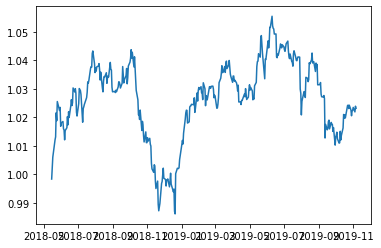

In [24]:
sharpe_port = np.mean(strat_rets.sum(axis=1)/len(instrument_list))/np.std(strat_rets.sum(axis=1)/len(instrument_list))
print(sharpe_port * np.sqrt(252))
print(sharpe_port)
plt.plot(strat_rets_cum.sum(axis=1)/len(instrument_list))

In [25]:
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle = False)
X_train, X_embargo, y_train, y_embargo = train_test_split(X_train, y_train, test_size=0.01, shuffle = False)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle = False)\nX_train, X_embargo, y_train, y_embargo = train_test_split(X_train, y_train, test_size=0.01, shuffle = False)\n'

In [26]:
'''
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train,y_train)
tree.score(X_train,y_train)
tree.score(X_test,y_test)
tree.feature_importances_
ddd = X_test.shape[0]
txx= 2*tree.predict(X_test)-1
txx[tree.predict_proba(X_test).max(axis=1)<=0.56] = 0
print(np.mean(y_rets[-ddd:-2]*txx[:-2])/np.std(y_rets[-ddd:-2]*txx[:-2]))
rets =(1+y_rets[-ddd:-2]*txx[:-2]).cumprod()
plt.plot((1+y_rets[-ddd:-2]*txx[:-2]).cumprod())
'''

'\ntree = DecisionTreeClassifier(max_depth=1)\ntree.fit(X_train,y_train)\ntree.score(X_train,y_train)\ntree.score(X_test,y_test)\ntree.feature_importances_\nddd = X_test.shape[0]\ntxx= 2*tree.predict(X_test)-1\ntxx[tree.predict_proba(X_test).max(axis=1)<=0.56] = 0\nprint(np.mean(y_rets[-ddd:-2]*txx[:-2])/np.std(y_rets[-ddd:-2]*txx[:-2]))\nrets =(1+y_rets[-ddd:-2]*txx[:-2]).cumprod()\nplt.plot((1+y_rets[-ddd:-2]*txx[:-2]).cumprod())\n'

In [27]:
'''
dot_data = export_graphviz(tree, out_file=None, 
                      feature_names=X_train.columns,  
                     class_names=[str(1),str(-1)],  
                     filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
'''

'\ndot_data = export_graphviz(tree, out_file=None, \n                      feature_names=X_train.columns,  \n                     class_names=[str(1),str(-1)],  \n                     filled=True, rounded=True,  \n                    special_characters=True)  \ngraph = graphviz.Source(dot_data)  \ngraph \n'

In [28]:
'''
random_forest = RandomForestClassifier(n_estimators=10000, max_features = 10, max_depth=15)
random_forest.fit(X_train,y_train)
random_forest_train_score = random_forest.score(X_train,y_train)
random_forest_test_score = random_forest.score(X_test,y_test)
print("Random forest accuracy on the train set: ", random_forest_train_score)
print("Random forest accuracy on the test set: ", random_forest_test_score)
'''

'\nrandom_forest = RandomForestClassifier(n_estimators=10000, max_features = 10, max_depth=15)\nrandom_forest.fit(X_train,y_train)\nrandom_forest_train_score = random_forest.score(X_train,y_train)\nrandom_forest_test_score = random_forest.score(X_test,y_test)\nprint("Random forest accuracy on the train set: ", random_forest_train_score)\nprint("Random forest accuracy on the test set: ", random_forest_test_score)\n'